In [ ]:
# import time
# time.sleep(10*60*60)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle

import pybamm
from datetime import datetime, timedelta
from time import time
import mscc_aging_test_DOD100 as worker
import multiprocessing as mp
from scipy.optimize import minimize
from joblib import Parallel, delayed

from LIB_GP import*
from LIB_acq_fun_min import*

print(pybamm.__version__)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

24.9.0


In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [4]:
init_seed = 1000
set_T_C = 25 
cap_specs = [0.86,0.84,0.82,0.80] # capacity retention spec

In [5]:
n_opt_start = 100
n_MV = 5

### 1. Initial data generation

In [6]:
initial_data = np.load(f'PrBO_initial_data.npy')

X_initial = initial_data[:,0:n_MV]
y_initial = initial_data[:,n_MV:]
n_initial = len(initial_data)
print(initial_data)

[[0.2        0.4        0.3        3.7        4.05       3.63587004
  0.86165137]
 [0.8        0.6        1.         3.7        4.1        1.49304886
  0.84761826]
 [1.         1.2        1.         3.8        3.95       0.9669533
  0.83026848]
 [1.4        1.4        1.         3.7        4.05       0.78265353
  0.81509486]]


In [7]:
noise_y1 = np.zeros(100)
noise_y2 = np.zeros(100)

In [8]:
df_io = pd.DataFrame(columns=['x1','x2','x3','x4','x5','y1','y2'])
df_io['x1'] = X_initial[:,0]
df_io['x2'] = X_initial[:,1]
df_io['x3'] = X_initial[:,2]
df_io['x4'] = X_initial[:,3]
df_io['x5'] = X_initial[:,4]
# df_io['y1'] = np.array(y_initial)[:,1]
# df_io['y2'] = np.array(y_initial)[:,0]
df_io['y1'] = y_initial[:,0]  #+ noise_y1[:len(y_initial[:,0])]
df_io['y2'] = y_initial[:,1]  #+ noise_y2[:len(y_initial[:,1])]
df_io

,x1,x2,x3,x4,x5,y1,y2
0,0.2,0.4,0.3,3.7,4.05,3.635870,0.861651
1,0.8,0.6,1.0,3.7,4.10,1.493049,0.847618
2,1.0,1.2,1.0,3.8,3.95,0.966953,0.830268
3,1.4,1.4,1.0,3.7,4.05,0.782654,0.815095


In [9]:
# x, y data 
X_io = df_io[['x1','x2','x3','x4','x5']].values
y_io = df_io[['y1','y2']].values
print(X_io)
print(y_io)

for s in range(len(cap_specs)):
    print(f'For capacity spec: {cap_specs[s]}')
    # How many samples satisfy capacity constraint?
    print(f'How many samples satisfy capacity constraint? ',(y_io[:,1] >=cap_specs[s]).sum(),'/',len(y_io))
    # Current ch_time best
    if (y_io[:,1] >=cap_specs[s]).sum() > 0: # constraint을 만족하는 sample이 하나라도 있을 때
        ch_time_best = df_io[df_io['y2']>=cap_specs[s]].sort_values('y1').iloc[0]['y1']
        print('Current minimum charging time [h]: ', ch_time_best)    
    else:
        print('No current minimum charging time')
    print('')

[[0.2  0.4  0.3  3.7  4.05]
 [0.8  0.6  1.   3.7  4.1 ]
 [1.   1.2  1.   3.8  3.95]
 [1.4  1.4  1.   3.7  4.05]]
[[3.63587004 0.86165137]
 [1.49304886 0.84761826]
 [0.9669533  0.83026848]
 [0.78265353 0.81509486]]
For capacity spec: 0.86
How many samples satisfy capacity constraint?  1 / 4
Current minimum charging time [h]:  3.6358700431704136

For capacity spec: 0.84
How many samples satisfy capacity constraint?  2 / 4
Current minimum charging time [h]:  1.4930488550570296

For capacity spec: 0.82
How many samples satisfy capacity constraint?  3 / 4
Current minimum charging time [h]:  0.9669532970602539

For capacity spec: 0.8
How many samples satisfy capacity constraint?  4 / 4
Current minimum charging time [h]:  0.7826535327190598



### 2. Bayesian optimization

In [10]:
kernel_type = 'RBF'
acq_type = 'EI'
BO_iter = 7

In [12]:
X_opt_start_candi = np.load('X_grid_var5.npy')
X_opt_start_candi

array([[0.2 , 0.2 , 0.2 , 3.7 , 3.95],
       [0.2 , 0.2 , 0.2 , 3.7 , 4.  ],
       [0.2 , 0.2 , 0.2 , 3.7 , 4.05],
       ...,
       [2.  , 2.  , 1.  , 3.85, 4.  ],
       [2.  , 2.  , 1.  , 3.85, 4.05],
       [2.  , 2.  , 1.  , 3.85, 4.1 ]])

In [13]:
len(X_opt_start_candi)

14400

#### Minimize charging time while cap retention > cap_spec %

In [14]:
import joblib
ecm_interp = joblib.load('ecm_interp_knn.pkl')

In [15]:
st_time = time()
ecm_interp_X_opt_candi = ecm_interp.predict(X_opt_start_candi)
ed_time = time()
print((ed_time-st_time)/60, 'minutes') # 1시간 정도 걸렸음

np.save('ecm_interp_X_opt_candi.npy',ecm_interp_X_opt_candi)

0.0008144736289978028 minutes


In [16]:
ecm_interp_X_opt_candi = np.load('ecm_interp_X_opt_candi.npy')

In [17]:
y_ECM = ecm_interp.predict(X_io)
print(y_io)
print(y_ECM)

[[3.63587004 0.86165137]
 [1.49304886 0.84761826]
 [0.9669533  0.83026848]
 [0.78265353 0.81509486]]
[[3.64567067 0.86012611]
 [1.49729116 0.84020466]
 [0.97002286 0.82002044]
 [0.78542323 0.80037281]]


In [18]:
def acq_neg(X,LIB_gp_y1,LIB_gp_y2,cap_spec,y_train):

    X = X.reshape(-1,n_MV)
    mu1, std1 = LIB_gp_y1.GP_predict(model_y1,X)
    mu2, std2 = LIB_gp_y2.GP_predict(model_y2,X)
    mu1 = mu1 + ecm_interp.predict(X).flatten()[0]
    mu2 = mu2 + ecm_interp.predict(X).flatten()[1]

    # Probability of Feasibility
    pf_y2_lb = 1-norm.cdf(cap_spec,loc=mu2, scale=std2)

    # Acquisition function
    if (y_train[:,1]>=cap_spec).sum()==0: #constraint만족하는 sample이 하나도 없을 때
        ac = pf_y2_lb
    else:
        ch_time_best = np.sort(y_train[y_train[:,1]>=cap_spec][:,0])[0]
        LIB_acq = LIB_acq_fun(mu1,std1,acq_type=acq_type)
        EI = LIB_acq.acq_fun(ch_time_best)    
        ac = pf_y2_lb * EI

    return -ac

# Or Local optimum search ##############################################################
## Pre-search로 X_opt_start 선별하기
def acq_cal(j,LIB_gp_y1,LIB_gp_y2,cap_spec,y_train):
    X_temp = X_opt_start_candi[j,:].reshape(-1,n_MV)
    ecm_interp_Xj = ecm_interp_X_opt_candi[j]
    mu1, std1 = LIB_gp_y1.GP_predict(model_y1,X_temp)
    mu2, std2 = LIB_gp_y2.GP_predict(model_y2,X_temp)
    mu1 = mu1 + ecm_interp_Xj[0]
    mu2 = mu2 + ecm_interp_Xj[1]

    # Probability of Feasibility
    pf_y2_lb = 1-norm.cdf(cap_spec,loc=mu2, scale=std2)

    # Acquisition function
    if (y_train[:,1]>=cap_spec).sum()==0: #constraint만족하는 sample이 하나도 없을 때
        ac = pf_y2_lb
    else:
        ch_time_best = np.sort(y_train[y_train[:,1]>=cap_spec][:,0])[0]
        LIB_acq = LIB_acq_fun(mu1,std1,acq_type=acq_type)
        EI = LIB_acq.acq_fun(ch_time_best)    
        ac = pf_y2_lb * EI    

    return ac

In [19]:
X_train, y_train = X_io, y_io 

st_st_time = time()
for iteration in range(BO_iter):
    print(f'BO iteration #{iteration}')
    st_time = time()
    
    y1_train = (y_train[:,0]-y_ECM[:,0]).reshape(-1,1)
    y2_train = (y_train[:,1]-y_ECM[:,1]).reshape(-1,1)
    
    LIB_gp_y1 = LIB_GP(kernel_type,alpha=1e-4)
    model_y1 = LIB_gp_y1.GP_fit(X_train,y1_train)
    LIB_gp_y2 = LIB_GP(kernel_type,alpha=1e-6)
    model_y2 = LIB_gp_y2.GP_fit(X_train,y2_train)

    
    print(model_y1.kernel_)
    print(model_y2.kernel_)
    R2score_y1 = LIB_gp_y1.GP_leave_one_out_cv_PrBO(X_train,y1_train,model_y1.kernel_,y_ECM[:,0],y_train[:,0])
    R2score_y2 = LIB_gp_y2.GP_leave_one_out_cv_PrBO(X_train,y2_train,model_y2.kernel_,y_ECM[:,1],y_train[:,1])    
    print('Leave-one-out cross validation, R2 score for y1: ', np.round(R2score_y1, 3))
    print('Leave-one-out cross validation, R2 score for y2: ', np.round(R2score_y2, 3))    
   
    ### 3. Acquisition function
    n_cores = 10
    acq_cal_result = Parallel(n_jobs=int(n_cores))(delayed(acq_cal)(j,LIB_gp_y1,LIB_gp_y2,cap_specs[0],y_train) for j in range(len(X_opt_start_candi)))
    acq_cal_result = np.array(acq_cal_result).flatten()
    X_opt_start = X_opt_start_candi[acq_cal_result.argsort()[::-1]][:n_opt_start]
    
    bnds = [(0.2,2.0),(0.2,2.0), (0.2,1.0), (3.7,3.85),(3.95,4.1)]
    def acq_opt(j):
        res = minimize(fun=acq_neg,x0=X_opt_start[j,:], method='SLSQP',bounds=bnds,args=(LIB_gp_y1,LIB_gp_y2,cap_specs[0],y_train))
        return res.x, -res.fun
    n_cores = -1
    n_starts = len(X_opt_start)
    ac_result = Parallel(n_jobs=int(n_cores))(delayed(acq_opt)(j) for j in range(n_starts))
    df_ac_result = pd.DataFrame(ac_result,columns=['X','acq fun'])
    df_ac_result_sort = df_ac_result.sort_values('acq fun',ascending=False)    
    next_X_1 = (np.round(df_ac_result_sort.iloc[0,0],4)).reshape(-1,n_MV)
    ########################################################################################
    
    ecm_next_X_1 = ecm_interp.predict(next_X_1).flatten()
    mu1_next_X_1, std1_next_X_1 = LIB_gp_y1.GP_predict(model_y1,next_X_1.reshape(-1,n_MV))
    mu2_next_X_1, std2_next_X_1 = LIB_gp_y2.GP_predict(model_y2,next_X_1.reshape(-1,n_MV))
    
    print('Batch 1 recom: ', next_X_1, ecm_next_X_1)
    print('Batch 1 pred:', ecm_next_X_1[0]+mu1_next_X_1, ecm_next_X_1[1] + mu2_next_X_1)
    print('Batch 1 std: ', std1_next_X_1, std2_next_X_1)
    ########################################################################################  
    
    # Batch BO 1 ##############################################################################  
    acq_cal_result = Parallel(n_jobs=int(n_cores))(delayed(acq_cal)(j,LIB_gp_y1,LIB_gp_y2,cap_specs[1],y_train) for j in range(len(X_opt_start_candi)))
    acq_cal_result = np.array(acq_cal_result).flatten()
    X_opt_start = X_opt_start_candi[acq_cal_result.argsort()[::-1]][:n_opt_start]
    
    def acq_opt(j):
        res = minimize(fun=acq_neg,x0=X_opt_start[j,:], method='SLSQP',bounds=bnds,args=(LIB_gp_y1,LIB_gp_y2,cap_specs[1],y_train))
        return res.x, -res.fun
    n_cores = -1
    n_starts = len(X_opt_start)
    ac_result = Parallel(n_jobs=int(n_cores))(delayed(acq_opt)(j) for j in range(n_starts))
    df_ac_result = pd.DataFrame(ac_result,columns=['X','acq fun'])
    df_ac_result_sort = df_ac_result.sort_values('acq fun',ascending=False)    
    next_X_2 = (np.round(df_ac_result_sort.iloc[0,0],4)).reshape(-1,n_MV)
    ########################################################################################
    
    ecm_next_X_2 = ecm_interp.predict(next_X_2).flatten()
    mu1_next_X_2, std1_next_X_2 = LIB_gp_y1.GP_predict(model_y1,next_X_2.reshape(-1,n_MV))
    mu2_next_X_2, std2_next_X_2 = LIB_gp_y2.GP_predict(model_y2,next_X_2.reshape(-1,n_MV))
    
    print('Batch 2 recom: ', next_X_2, ecm_next_X_2)
    print('Batch 2 pred:', ecm_next_X_2[0]+mu1_next_X_2, ecm_next_X_2[1] + mu2_next_X_2)
    print('Batch 2 std: ', std1_next_X_2, std2_next_X_2)
    ########################################################################################     
    
    # Batch BO 2 ##############################################################################  
    acq_cal_result = Parallel(n_jobs=int(n_cores))(delayed(acq_cal)(j,LIB_gp_y1,LIB_gp_y2,cap_specs[2],y_train) for j in range(len(X_opt_start_candi)))
    acq_cal_result = np.array(acq_cal_result).flatten()
    X_opt_start = X_opt_start_candi[acq_cal_result.argsort()[::-1]][:n_opt_start]

    def acq_opt(j):
        res = minimize(fun=acq_neg,x0=X_opt_start[j,:], method='SLSQP',bounds=bnds,args=(LIB_gp_y1,LIB_gp_y2,cap_specs[2],y_train))
        return res.x, -res.fun
    n_cores = 10
    n_starts = len(X_opt_start)
    ac_result = Parallel(n_jobs=int(n_cores))(delayed(acq_opt)(j) for j in range(n_starts))
    df_ac_result = pd.DataFrame(ac_result,columns=['X','acq fun'])
    df_ac_result_sort = df_ac_result.sort_values('acq fun',ascending=False)    
    next_X_3 = (np.round(df_ac_result_sort.iloc[0,0],4)).reshape(-1,n_MV)
    ########################################################################################
    
    ecm_next_X_3 = ecm_interp.predict(next_X_3).flatten()
    mu1_next_X_3, std1_next_X_3 = LIB_gp_y1.GP_predict(model_y1,next_X_3.reshape(-1,n_MV))
    mu2_next_X_3, std2_next_X_3 = LIB_gp_y2.GP_predict(model_y2,next_X_3.reshape(-1,n_MV))
    
    print('Batch 3 recom: ', next_X_3, ecm_next_X_3)
    print('Batch 3 pred:', ecm_next_X_3[0]+mu1_next_X_3, ecm_next_X_3[1] + mu2_next_X_3)
    print('Batch 3 std: ', std1_next_X_3, std2_next_X_3)
    ########################################################################################      
    
    # Batch BO 3 ##############################################################################  
    acq_cal_result = Parallel(n_jobs=int(n_cores))(delayed(acq_cal)(j,LIB_gp_y1,LIB_gp_y2,cap_specs[3],y_train) for j in range(len(X_opt_start_candi)))
    acq_cal_result = np.array(acq_cal_result).flatten()
    X_opt_start = X_opt_start_candi[acq_cal_result.argsort()[::-1]][:n_opt_start]
    
    def acq_opt(j):
        res = minimize(fun=acq_neg,x0=X_opt_start[j,:], method='SLSQP',bounds=bnds,args=(LIB_gp_y1,LIB_gp_y2,cap_specs[3],y_train))
        return res.x, -res.fun
    n_cores = 10
    n_starts = len(X_opt_start)
    ac_result = Parallel(n_jobs=int(n_cores))(delayed(acq_opt)(j) for j in range(n_starts))
    df_ac_result = pd.DataFrame(ac_result,columns=['X','acq fun'])
    df_ac_result_sort = df_ac_result.sort_values('acq fun',ascending=False)    
    next_X_4 = (np.round(df_ac_result_sort.iloc[0,0],4)).reshape(-1,n_MV)
    ########################################################################################
    
    ecm_next_X_4 = ecm_interp.predict(next_X_4).flatten()
    mu1_next_X_4, std1_next_X_4 = LIB_gp_y1.GP_predict(model_y1,next_X_4.reshape(-1,n_MV))
    mu2_next_X_4, std2_next_X_4 = LIB_gp_y2.GP_predict(model_y2,next_X_4.reshape(-1,n_MV))
    
    print('Batch 4 recom: ', next_X_4, ecm_next_X_4)
    print('Batch 4 pred:', ecm_next_X_4[0]+mu1_next_X_4, ecm_next_X_4[1] + mu2_next_X_4)
    print('Batch 4 std: ', std1_next_X_4, std2_next_X_4)
    ########################################################################################         
    next_X_tot = np.concatenate([next_X_1,next_X_2,next_X_3,next_X_4]).reshape(-1,n_MV)      
    p = mp.Pool(processes = 3) # 병렬 3개
    next_y_EM = p.starmap(worker.aging_test_results,next_X_tot)
    next_y_EM = np.array(next_y_EM).reshape(-1,2)
    next_y1_noise = next_y_EM[:,0]#+ noise_y1[3*iteration+len(X_initial):3*(iteration+1)+len(X_initial)]
    next_y2_noise = next_y_EM[:,1]#+ noise_y2[3*iteration+len(X_initial):3*(iteration+1)+len(X_initial)]
    next_y_tot = np.concatenate([next_y1_noise,next_y2_noise]).reshape(-1,4).transpose()     
    print(f'BO iteration #{iteration}:')
    print(np.concatenate([next_X_tot,next_y_tot],axis=1))
    ed_time = time()
    print(f'It takes {np.round((ed_time-st_time)/60,3)} min')
    print('')
    X_train = np.append(X_train,next_X_tot).reshape(-1,n_MV)
    y_train = np.append(y_train,next_y_tot).reshape(-1,2)
    ecm_next_X_tot = ecm_interp.predict(next_X_tot)
    y_ECM = np.append(y_ECM, ecm_next_X_tot.reshape(-1,2)).reshape(-1,2)
    data_save = np.concatenate([X_train,y_train],axis=1)
    np.save(f'PrBO_var{n_MV}_iter{iteration}.npy',data_save)
ed_ed_time = time()
print(f'In total, it takes {np.round((ed_ed_time-st_st_time)/3600,3)} hr')

BO iteration #0
0.00316**2 * RBF(length_scale=1e+03)
0.0122**2 * RBF(length_scale=2.44)
Leave-one-out cross validation, R2 score for y1:  1.0
Leave-one-out cross validation, R2 score for y2:  0.998
Batch 1 recom:  [[0.4  2.   0.4  3.85 3.95]] [2.49924477 0.85410094]
Batch 1 pred: [2.49782461] [0.86186864]
Batch 1 std:  [0.00267261] [0.00424491]
Batch 2 recom:  [[0.8823 0.888  0.9302 3.7001 4.0983]] [1.19391308 0.8305449 ]
Batch 2 pred: [1.19249293] [0.8395384]
Batch 2 std:  [0.00267261] [0.00073901]
Batch 3 recom:  [[1.4471 1.2878 1.     3.7    4.0489]] [0.8356181  0.80644414]
Batch 3 pred: [0.83419795] [0.82051446]
Batch 3 std:  [0.00267261] [0.00103095]
Batch 4 recom:  [[1.5504 1.5    1.     3.7    4.1   ]] [0.73634461 0.78663802]
Batch 4 pred: [0.73492446] [0.80194972]
Batch 4 std:  [0.00267261] [0.00121743]
BO iteration #0:
[[0.4        2.         0.4        3.85       3.95       2.48675645
  0.85610637]
 [0.8823     0.888      0.9302     3.7001     4.0983     1.11401487
  0.837034

In [20]:
data_save = np.concatenate([X_train,y_train],axis=1)
np.save(f'PrBO_var{n_MV}.npy',data_save)

In [21]:
len(X_train)

32

In [22]:
print(X_train)
print(y_train)

[[0.2    0.4    0.3    3.7    4.05  ]
 [0.8    0.6    1.     3.7    4.1   ]
 [1.     1.2    1.     3.8    3.95  ]
 [1.4    1.4    1.     3.7    4.05  ]
 [0.4    2.     0.4    3.85   3.95  ]
 [0.8823 0.888  0.9302 3.7001 4.0983]
 [1.4471 1.2878 1.     3.7    4.0489]
 [1.5504 1.5    1.     3.7    4.1   ]
 [0.4936 0.3007 1.     3.7007 4.0978]
 [0.8908 0.7092 1.     3.7002 4.0785]
 [1.4898 1.2786 1.     3.7015 4.0654]
 [1.6    1.4    1.     3.8    4.1   ]
 [0.4    0.4    1.     3.85   4.1   ]
 [1.0679 0.7458 1.     3.7206 3.9706]
 [1.4889 1.4671 0.998  3.838  4.0192]
 [1.6015 1.5    1.     3.8478 4.1   ]
 [0.4    0.4    1.     3.7    4.1   ]
 [0.8918 0.8378 0.9932 3.7104 4.043 ]
 [1.2936 1.2973 0.9996 3.7    4.0506]
 [1.5028 1.5    0.9856 3.7957 4.0957]
 [0.488  0.3099 0.729  3.7646 4.0858]
 [1.0171 0.7125 0.9739 3.7    4.0998]
 [1.3026 1.2912 0.9991 3.7001 4.1   ]
 [1.6471 1.5001 1.     3.771  4.1   ]
 [0.9999 0.4    1.     3.7    4.1   ]
 [0.9995 0.8038 1.     3.7005 4.1   ]
 [1.1768 1.2

In [23]:
for s in range(len(cap_specs)):
    print(f'Batch {s+1}')
    cap_spec = cap_specs[s]
    print(cap_spec)
    
    if (y_train[:,1]>=cap_spec).sum()>=1:
        print('Cap')
        X_best = X_train[y_train[:,1]>=cap_spec][np.argmin(y_train[:,0][y_train[:,1]>=cap_spec])]
        y_best = y_train[y_train[:,1]>=cap_spec][np.argmin(y_train[:,0][y_train[:,1]>=cap_spec])]
    else:
        print('Max')
        X_best = X_train[np.argmax(y_train[:,1])]
        y_best = y_train[np.argmax(y_train[:,1])]
    y_best[0]*=60
    y_best[1]*=100
    print('X_best found: ',X_best)
    print('y_best found: ',y_best)
    print('')

Batch 1
0.86
Cap
X_best found:  [0.4936 0.3007 1.     3.7007 4.0978]
y_best found:  [168.0044732   86.02341689]

Batch 2
0.84
Cap
X_best found:  [1.0171 0.7125 0.9739 3.7    4.0998]
y_best found:  [75.58616514 84.24692879]

Batch 3
0.82
Cap
X_best found:  [1.2936 1.2973 0.9996 3.7    4.0506]
y_best found:  [49.42324433 82.01154096]

Batch 4
0.8
Cap
X_best found:  [1.6015 1.5    1.     3.8478 4.1   ]
y_best found:  [42.58845035 80.05067986]



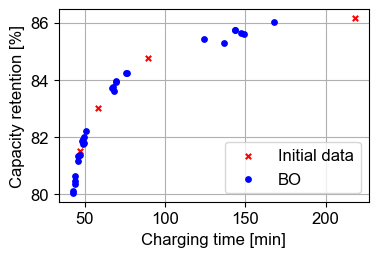

In [25]:
import matplotlib.pyplot as plt 
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
import numpy as np
X_train = np.load('PrBO_var5.npy')[:,:5]
y_train = np.load('PrBO_var5.npy')[:,-2:]
n_initial = 4
plt.rcParams['font.size'] = 12
plt.figure(1,figsize=(4,2.5))
plt.grid(zorder=0)

plt.scatter(y_train[:n_initial,0]*60,y_train[:n_initial,1]*100,zorder=5,c='r',s=15,marker='x',label='Initial data')
plt.scatter(y_train[n_initial:,0]*60,y_train[n_initial:,1]*100,zorder=5,c='b',s=15,label='BO')
# plt.xlim(30,250)
# plt.ylim(0.6,0.83)
plt.xlabel('Charging time [min]')
plt.ylabel('Capacity retention [%]')
plt.legend()
plt.show()